# Housing Prices Competition

# Dataset: https://www.kaggle.com/competitions/home-data-for-ml-course/overview

# Objetive: 
    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Evaluation : 
    Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# -------------------------------------------------------------------------------------------------------------------------------------------
# Data exploration

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as ms

In [30]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Train_df

(1460, 81)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<AxesSubplot: >

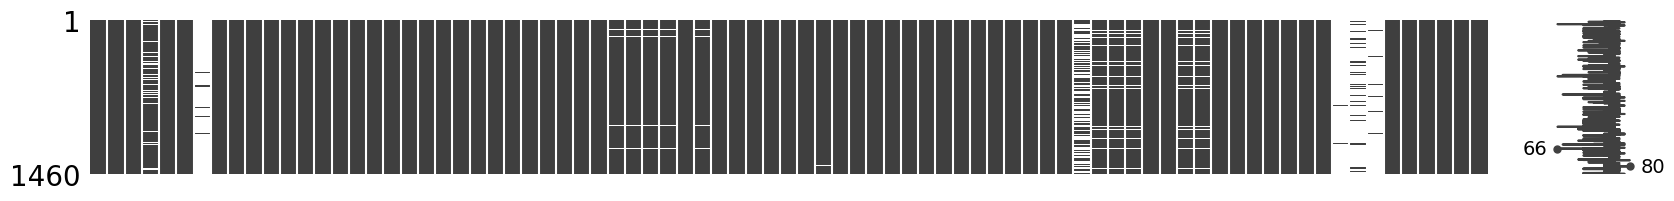

In [3]:
display(train_df.shape, train_df.head(), ms.matrix(train_df, figsize=(20,2)))

# Test_df

(1459, 80)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<AxesSubplot: >

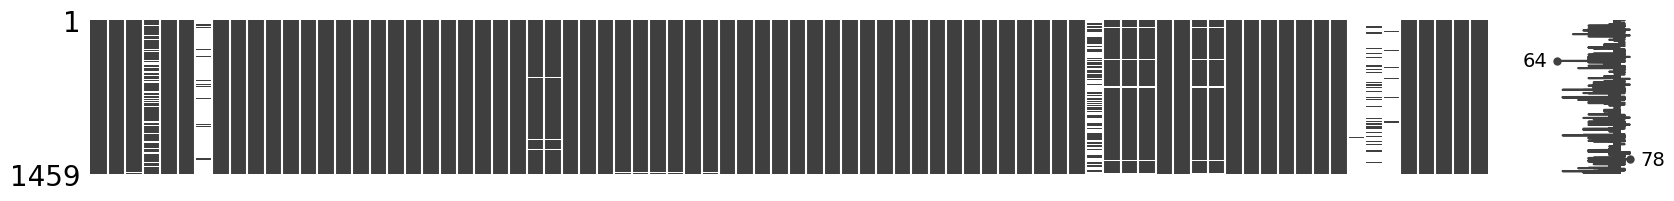

In [4]:
display(test_df.shape, test_df.head(), ms.matrix(test_df, figsize=(20,2)))

# Correlations

In [34]:
train_df_corr = train_df.corr()
dependent_var_corrs = train_df_corr.nlargest(1000,"SalePrice")["SalePrice"]
dependent_var_corrs = dependent_var_corrs[dependent_var_corrs.values > 0.5]
dependent_var_corrs

/tmp/ipykernel_18594/3483109693.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df_corr = train_df.corr()


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

# Let's reduce the data

In [5]:
# Count high NaN columns
nan_l = train_df.isna().sum()
for x in range(len(nan_l)):
    if nan_l[x] > 0:
        print(train_df.columns[x], nan_l[x])

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


In [6]:
print(train_df['Alley'].isna().sum() * 100 / len(train_df),
      train_df['PoolQC'].isna().sum() * 100 / len(train_df),
      train_df['Fence'].isna().sum() * 100 / len(train_df),
      train_df['MiscFeature'].isna().sum() * 100 / len(train_df),
      train_df['FireplaceQu'].isna().sum() * 100 / len(train_df))

93.76712328767124 99.52054794520548 80.75342465753425 96.3013698630137 47.26027397260274


## Drops

In [7]:
train_df = train_df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Id'], axis=1)

# Pull apart num cols and object cols

In [8]:
object_df = train_df.select_dtypes(include=object)
object_df['SalePrice'] = train_df['SalePrice']
object_df.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000


In [9]:
nums_df = train_df.select_dtypes(include=np.number)
nums_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


# Inspect num cols

In [10]:
nums_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
nums_df['SalePrice'].describe(percentiles=[0.25, 0.50, 0.75])

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [12]:
# Cuts
p_low = nums_df['SalePrice'].describe(percentiles=[0.25, 0.50, 0.75])[4]
p_medium = nums_df['SalePrice'].describe(percentiles=[0.25, 0.50, 0.75])[5]
p_high = nums_df['SalePrice'].describe(percentiles=[0.25, 0.50, 0.75])[6]
nums_df['cut_SalePrice'] = pd.cut(nums_df['SalePrice'],
                                 bins=[0, p_low, p_medium, p_high, nums_df['SalePrice'].max()],
                                 labels=['Low', 'Medium', 'High', 'Very-High'],
                                 include_lowest=True)
nums_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,cut_SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,61,0,0,0,0,0,2,2008,208500,High
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,0,5,2007,181500,High
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,42,0,0,0,0,0,9,2008,223500,Very-High
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,35,272,0,0,0,0,2,2006,140000,Medium
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,84,0,0,0,0,0,12,2008,250000,Very-High


In [13]:
lowp_nums_df = nums_df.query("cut_SalePrice == 'Low'")
mediump_nums_df = nums_df.query("cut_SalePrice == 'Medium'")
highp_nums_df = nums_df.query("cut_SalePrice == 'High'")
veryhighp_nums_df = nums_df.query("cut_SalePrice == 'Very-High'")

In [14]:
len(lowp_nums_df) + len(mediump_nums_df) + len(highp_nums_df) + len(veryhighp_nums_df), len(nums_df['SalePrice'])

(1460, 1460)

In [15]:
result = nums_df.drop('SalePrice', axis=1).groupby('cut_SalePrice').agg('mean')
result.reset_index()

,cut_SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,Low,57.863014,60.015244,7753.967123,4.810959,5.575342,1945.328767,1968.471233,29.879452,249.578082,...,306.753425,42.263014,23.873973,37.369863,0.493151,3.978082,0.000000,37.709589,6.126027,2007.876712
1,Medium,58.732970,67.559322,9509.997275,5.531335,5.888283,1962.885559,1979.757493,69.833787,451.166213,...,423.580381,78.422343,28.416894,25.019074,2.773842,15.359673,1.307902,70.708447,6.247956,2007.828338
2,High,61.666667,70.643110,10117.844262,6.420765,5.428962,1984.647541,1991.931694,99.470914,407.234973,...,498.751366,108.857923,54.841530,12.139344,5.535519,19.366120,3.344262,40.792350,6.240437,2007.806011
3,Very-High,49.240331,83.128814,14726.715470,7.649171,5.406077,1992.392265,1999.430939,217.568245,668.486188,...,664.610497,147.922652,79.859116,13.226519,4.845304,21.580110,6.419890,24.447514,6.676796,2007.751381


In [16]:
def plot_data_distribution(df, column_name, column_to_comp):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
    ax1 = sns.countplot(ax=axes[0], data=df, x=column_name)
    temp = df[[column_name, column_to_comp]].groupby(column_name).agg('mean').reset_index()
    temp_order = temp.sort_values(column_to_comp, ascending=False)
    ax2 = sns.barplot(ax=axes[1], data=temp, x=column_to_comp, y=column_name, order=temp_order[column_name])
    plt.show()

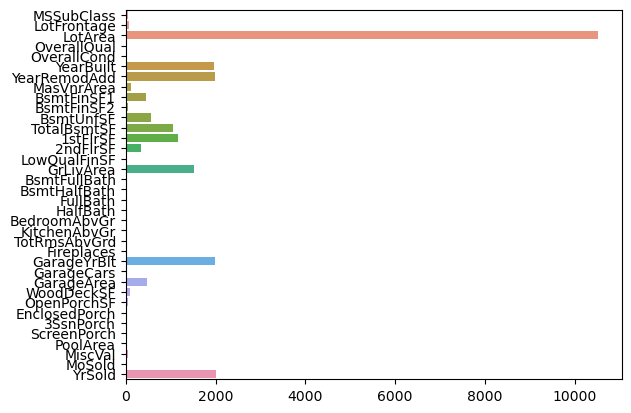

In [17]:
ax = sns.barplot(data=result, orient='h', errorbar=None)

In [18]:
corr_matrix = nums_df.drop('cut_SalePrice', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [cols for cols in upper.columns if any(upper[cols] > 0.80)]
to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

In [19]:
train_df = train_df.drop(to_drop, axis=1)

## Function for clean future DFs

In [20]:
def drop_trash(df):
    return(df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Id', '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea'], axis=1))

## Modeling

In [12]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import Pool, CatBoostRegressor
# Metrics
from sklearn.metrics import mean_squared_error as mse


In [23]:
# Equal categorical values between train_df and test_df
test_df = (drop_trash(test_df))
t_train = (train_df.drop('SalePrice', axis=1)).copy()

print('Cols no included in test_df:')
for col in train_df.select_dtypes(include=object).columns:
    for val in t_train[col].unique():
            if val not in test_df[col].unique():
                print(t_train[col].name, val, len(t_train.loc[t_train[col] == val]))
                train_df[col].loc[train_df[col] == val] = np.nan

Cols no included in test_df:
Utilities NoSeWa 1
Condition2 RRNn 2
Condition2 RRAn 1
Condition2 RRAe 1
HouseStyle 2.5Fin 8
RoofMatl Metal 1
RoofMatl Membran 1
RoofMatl Roll 1
RoofMatl ClyTile 1
Exterior1st Stone 2
Exterior1st ImStucc 1
Exterior2nd Other 1
MasVnrType nan 0
BsmtQual nan 0
BsmtCond nan 0
BsmtExposure nan 0
BsmtFinType1 nan 0
BsmtFinType2 nan 0
Heating OthW 2
Heating Floor 1
Electrical Mix 1
Electrical nan 0
GarageType nan 0
GarageFinish nan 0
GarageQual nan 0
GarageQual Ex 3
GarageCond nan 0


/tmp/ipykernel_14943/3760378524.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col].loc[train_df[col] == val] = np.nan


In [24]:
train_df['Condition2'].unique(), test_df['Condition2'].unique()

(array(['Norm', 'Artery', nan, 'Feedr', 'PosN', 'PosA'], dtype=object),
 array(['Norm', 'Feedr', 'PosA', 'PosN', 'Artery'], dtype=object))

In [171]:
# Preprocessor Pipeline
cat_features = train_df.select_dtypes(include=object).columns
num_features = train_df.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

In [172]:
# RandomForestRegressor
np.random.seed(42)

X = preprocessor.fit_transform(train_df.drop('SalePrice', axis=1))
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)
model = RandomForestRegressor()

print('Trainning......')
model.fit(X_train, y_train)
l_models[f'{model}'] = {'MSE': mse(y_test, model.predict(X_test))}
mse(y_test, model.predict(X_test))

Trainning......


748603368.9950792

In [3]:
class Training_df:
    def __init__(self, df, pred_col, models, plot_flag):
        self.df = df
        self.pred_col = pred_col
        self.models = models
        self.plot_flag = plot_flag
        
    def get_Xy(self, df, pred_col):
        X = df.drop(pred_col, axis=1)
        y = df[pred_col]
        return X, y
    
    def train_model(self, X, y, model):
        pre_X, _feat_names = self.processor(X)
        X_train, X_test, y_train, y_test = train_test_split(pre_X, y)
        _model = model
        print(f'Trainig {_model} ..........')
        _model.fit(X_train, y_train)
        try: _feat_imp = model.feature_importances_
        except: _feat_imp = 0
        return _model.score(X_test, y_test), _feat_imp, _feat_names
    
    def processor(self, X):
        cat_features = X.select_dtypes(include=object).columns
        num_features = X.select_dtypes(include=np.number).columns

        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        num_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', cat_transformer, cat_features),
                ('num', num_transformer, num_features)
            ]
        )
        return preprocessor.fit_transform(X), preprocessor.get_feature_names_out()
    
    def get_feat_importances_df(self, _feat_imp, name, _feat_names):
        feat_imp = pd.DataFrame({f'features {name}':_feat_names,
                                 'importance':_feat_imp})
        feat_imp = feat_imp.sort_values(by='importance', ascending=False).head(10)
        return feat_imp
    
    def plot_results(self, feat_importances):
        item_del = []
        f_imp = [x for x in feat_importances if x['importance'].mean() > 0]
        if len(f_imp) > 5:
            print('\033[31m' + f'Max subplots are set in 5, and u are trying to subplot {len(f_imp)} (All_data count 1)' + '\033[0m')
        else:
            fig, ax = plt.subplots(ncols=1, nrows=len(f_imp), figsize=(20,10))
            if len(f_imp) == 1:
                _ax = sns.barplot(data=f_imp[0], x='importance', y=f_imp[0].columns[0])
                _ax.set(title=f'Importance {f_imp[0].columns[0]}', ylabel='', xlabel='')
            else:
                for x in range(len(f_imp)):
                    _ax = sns.barplot(ax=ax[x], data=f_imp[x], x='importance', y=f_imp[x].columns[0])
                    _ax.set(title=f'Importance {f_imp[x].columns[0]}', ylabel='', xlabel='')
            plt.show()
        
    def get_res_df(self, results):
        res_df = pd.DataFrame({'Score':results.values()},
                              index=results.keys())
        return res_df.sort_values(by='Score', ascending=False).head(20)
    
    def start_training(self):
        print(f'Starting training for a list of {len(self.models)} models.......')
        results = {}
        feat_importances = []
        for x in range(len(self.models)):
            X, y = self.get_Xy(self.df, self.pred_col)
            _score, _feat_imp, _feat_names = (self.train_model(X, y, self.models[x]))
            results[f'{self.models[x]}'] = _score
            feat_importances.append(self.get_feat_importances_df(_feat_imp, f'{self.models[x]} / {_score:.4f}', _feat_names))
        print(self.get_res_df(results))
        if self.plot_flag == True:
            self.plot_results(feat_importances)
        return feat_importances

# Try different models

Starting training for a list of 3 models.......
Trainig LinearRegression() ..........
Trainig KNeighborsRegressor() ..........
Trainig <catboost.core.CatBoostRegressor object at 0x7f1a7a8b3b50> ..........
                                                       Score
LinearRegression()                                  0.871184
<catboost.core.CatBoostRegressor object at 0x7f...  0.867095
KNeighborsRegressor()                               0.574004


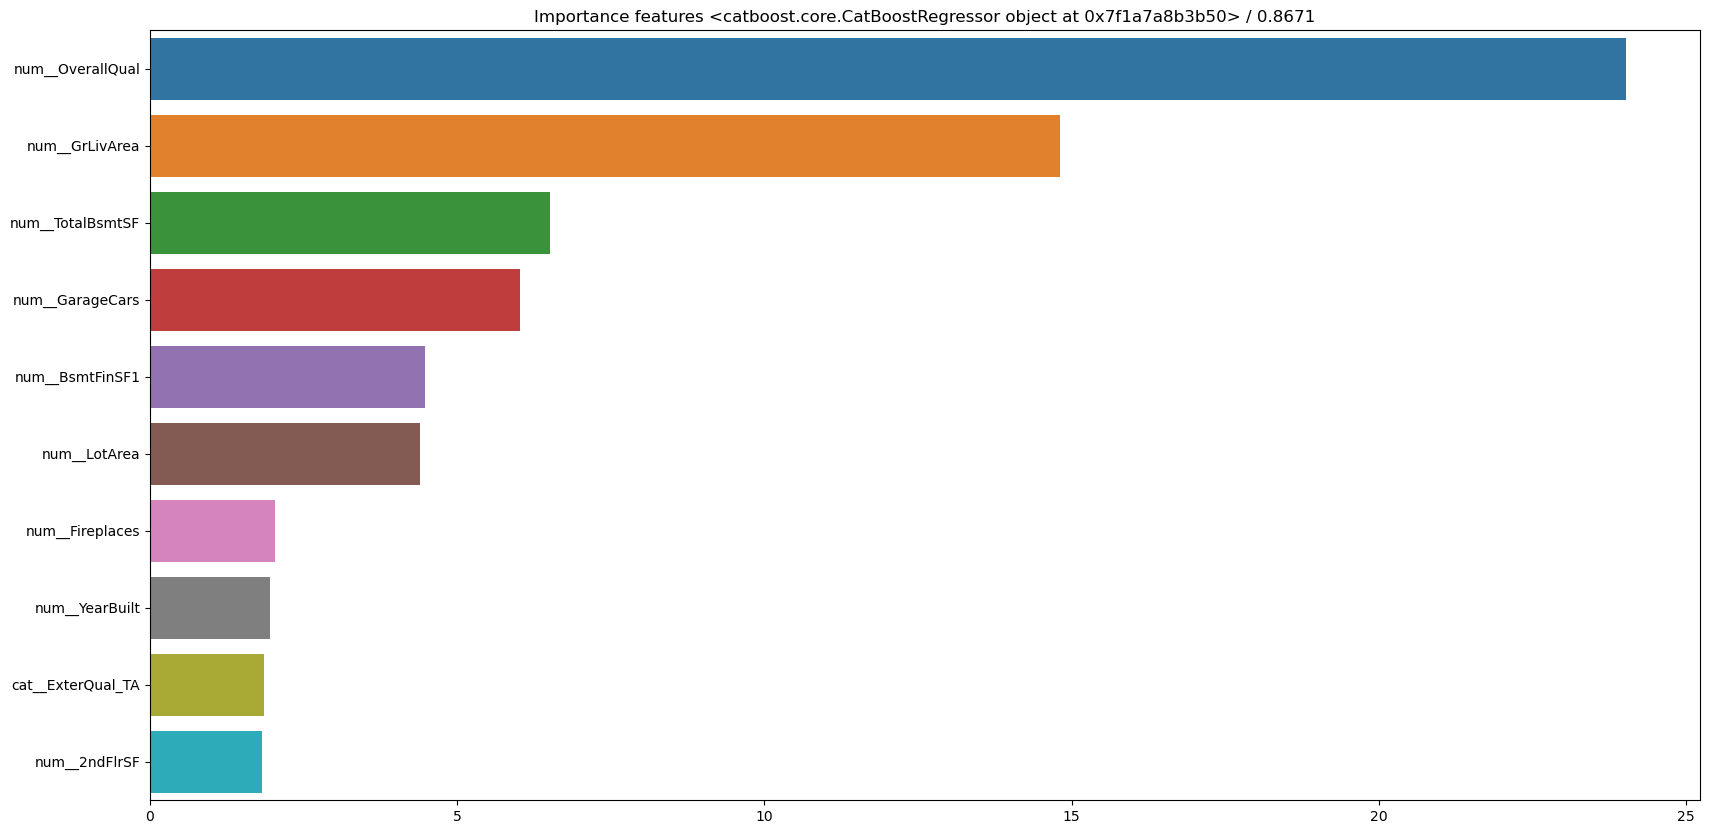

In [285]:
np.random.seed(42)
l_models = [LinearRegression(), KNeighborsRegressor(), CatBoostRegressor(logging_level='Silent')]

m_test1 = Training_df(train_df, 'SalePrice', l_models, True)
f_imp = m_test1.start_training()

# Let's try with CatBoost

## Simple

In [173]:
np.random.seed(42)
X = preprocessor.fit_transform(train_df.drop('SalePrice', axis=1))
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)
pool = Pool(X_train,
           y_train)
model = CatBoostRegressor(logging_level='Silent')
print('Training...... Catbost')
model.fit(pool)
model.score(X_test, y_test)

Trainning...... Catbost


0.9131662863058869

In [30]:
preprocessor.get_feature_names_out().shape, model.get_feature_importance().shape

((250,), (250,))

In [31]:
feat_imp1 = pd.DataFrame({'features':preprocessor.get_feature_names_out(),
                                      'importance':model.get_feature_importance()})
feat_imp1 = feat_imp1.sort_values(by='importance', ascending=False)
feat_imp1.head()

,features,importance
221,num__OverallQual,23.368867
232,num__GrLivArea,14.662638
229,num__TotalBsmtSF,5.892639
240,num__GarageCars,5.274999
226,num__BsmtFinSF1,5.035696


# With all the data

In [231]:
temp = pd.read_csv('train.csv')
temp = temp.drop(['Id', 'PoolQC', 'MiscFeature'], axis=1)
temp.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


In [251]:
np.random.seed(42)
l_models = [CatBoostRegressor(logging_level='Silent'), LinearRegression()]
m_test2 = Training_df(temp, 'SalePrice', l_models, False)
f_imp = m_test2.start_training()

Starting training for a list of 2 models.......
Trainig <catboost.core.CatBoostRegressor object at 0x7f1a8d42a200> ..........
Trainig LinearRegression() ..........
                                                       Score
<catboost.core.CatBoostRegressor object at 0x7f...  0.914964
LinearRegression()                                  0.861093


In [255]:
f_imp[0]

,features <catboost.core.CatBoostRegressor object at 0x7f1a8d42a200> / 0.9150,importance
248,num__OverallQual,24.010222
260,num__GrLivArea,14.198901
270,num__GarageCars,4.638014
253,num__BsmtFinSF1,4.423225
257,num__1stFlrSF,3.972461
256,num__TotalBsmtSF,3.867077
247,num__LotArea,3.056971
212,cat__GarageFinish_Unf,2.361156
268,num__Fireplaces,2.186708
258,num__2ndFlrSF,1.947921


In [248]:
temp2 = pd.read_csv('test.csv')
temp2 = temp2.drop('Id', axis=1)

In [35]:
# Equal categorical values between train_df and test_df
t_train = (temp.drop('SalePrice', axis=1)).copy()

print('Cols no included in test_df:')
for col in train_df.select_dtypes(include=object).columns:
    for val in t_train[col].unique():
            if val not in temp2[col].unique():
                print(t_train[col].name, val, len(t_train.loc[t_train[col] == val]))
                temp[col].loc[temp[col] == val] = np.nan

Cols no included in test_df:
Utilities NoSeWa 1
Condition2 RRNn 2
Condition2 RRAn 1
Condition2 RRAe 1
HouseStyle 2.5Fin 8
RoofMatl Metal 1
RoofMatl Membran 1
RoofMatl Roll 1
RoofMatl ClyTile 1
Exterior1st Stone 2
Exterior1st ImStucc 1
Exterior2nd Other 1
MasVnrType nan 0
BsmtQual nan 0
BsmtCond nan 0
BsmtExposure nan 0
BsmtFinType1 nan 0
BsmtFinType2 nan 0
Heating OthW 2
Heating Floor 1
Electrical Mix 1
Electrical nan 0
GarageType nan 0
GarageFinish nan 0
GarageQual nan 0
GarageQual Ex 3
GarageCond nan 0


/tmp/ipykernel_14943/884584030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[col].loc[temp[col] == val] = np.nan


In [19]:
# Preprocessor
cat_features = temp.select_dtypes(include=object).columns
num_features = temp.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

NameError: name 'temp' is not defined

In [37]:
X = temp.drop('SalePrice', axis=1)
y = temp['SalePrice']

In [38]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y)
pool = Pool(X_train,
           y_train)
model = CatBoostRegressor(logging_level='Silent')
print('Training...... Catbost')
model.fit(pool)
model.score(X_test, y_test)

Trainning...... Catbost


0.9174277749759084

In [39]:
preds = model.predict(preprocessor.fit_transform(temp2))

In [40]:
feat_imp2 = pd.DataFrame({'features':preprocessor.get_feature_names_out(),
                                      'importance':model.get_feature_importance()})
feat_imp2 = feat_imp2.sort_values(by='importance', ascending=False)
feat_imp2.head()

,features,importance
232,num__OverallQual,26.266634
244,num__GrLivArea,13.037085
241,num__1stFlrSF,4.819453
237,num__BsmtFinSF1,4.054395
231,num__LotArea,3.967830


In [41]:
corr_matrix = nums_df.drop('cut_SalePrice', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [cols for cols in upper.columns if any(upper[cols] > 0.80)]
to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

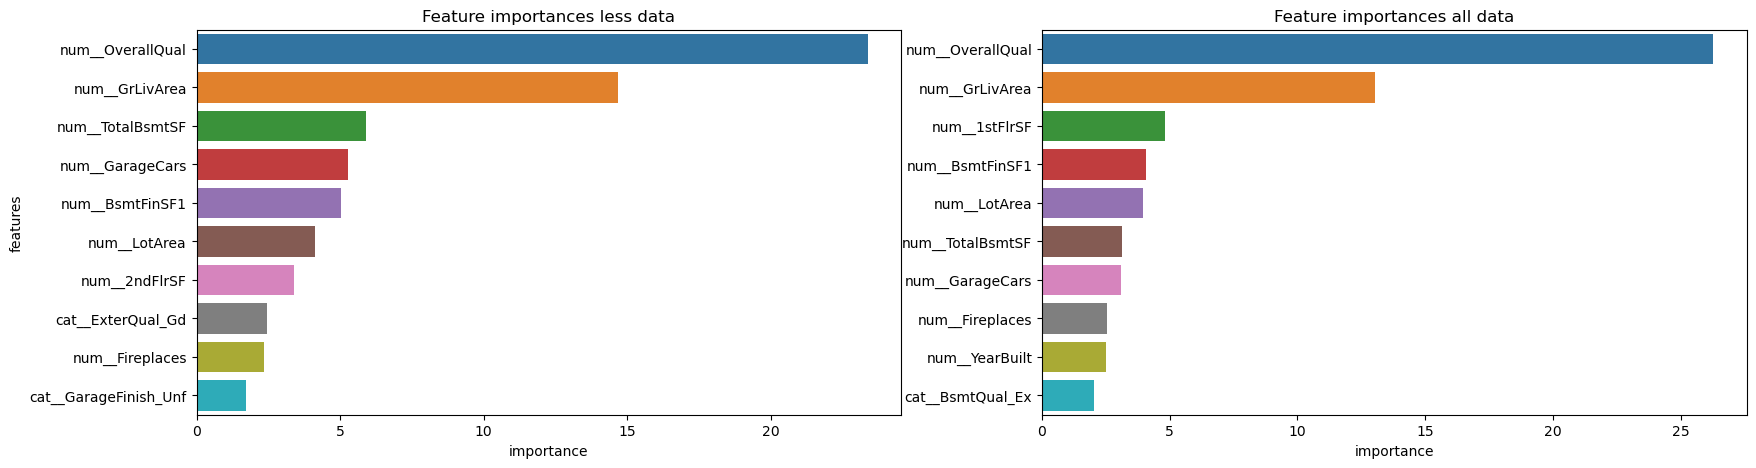

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
ax1 = sns.barplot(ax=axes[0], data=feat_imp1.head(10), x='importance', y='features')
ax1.set(title='Feature importances less data')
ax2 = sns.barplot(ax=axes[1], data=feat_imp2.head(10), x='importance', y='features')
ax2.set(title='Feature importances all data', ylabel='')
plt.show()

# Drop protocol 

In [4]:
class DropProtocol:
    def __init__(self, df, drop_col_list, pred_col, model, plot_flag):
        self.df = df
        self.drop_col_list = drop_col_list
        self.pred_col = pred_col
        self.model = model
        self.plot_flag = plot_flag
        
    def get_Xy(self, df, pred_col):
        X = df.drop(pred_col, axis=1)
        y = df[pred_col]
        return X, y
    
    def train_model(self, X, y, model):
        pre_X, _feat_names = self.processor(X)
        X_train, X_test, y_train, y_test = train_test_split(pre_X, y)
        _model = model
        _model.fit(X_train, y_train)
        _feat_imp = model.feature_importances_
        return _model.score(X_test, y_test), _feat_imp, _feat_names
    
    def processor(self, X):
        cat_features = X.select_dtypes(include=object).columns
        num_features = X.select_dtypes(include=np.number).columns

        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        num_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', cat_transformer, cat_features),
                ('num', num_transformer, num_features)
            ]
        )
        return preprocessor.fit_transform(X), preprocessor.get_feature_names_out()
    
    def get_feat_importances_df(self, _feat_imp, name, _feat_names):
        feat_imp = pd.DataFrame({f'features {name}':_feat_names,
                                 'importance':_feat_imp})
        feat_imp = feat_imp.sort_values(by='importance', ascending=False).head(10)
        return feat_imp
    
    def plot_results(self, feat_importances):
        if len(feat_importances) > 5:
            print('\033[31m' + f'Max subplots are set in 5, and u are trying to subplot {len(feat_importances)} (All_data count 1)' + '\033[0m')
        else:
            fig, ax = plt.subplots(ncols=1, nrows=len(feat_importances), figsize=(20,10), sharex=True)
            for x in range(len(feat_importances)):
                _ax = sns.barplot(ax=ax[x], data=feat_importances[x], x='importance', y=feat_importances[x].columns[0])
                _ax.set(title=f'Importance {feat_importances[x].columns[0]}', ylabel='', xlabel='')
            plt.show()
        
    def get_res_df(self, results):
        res_df = pd.DataFrame({'Score':results.values()},
                              index=results.keys())
        return res_df.sort_values(by='Score', ascending=False).head(20)
    
    def drop_protocol(self):
        print(f'Starting Drop-Protocol for a list of {len(self.drop_col_list)} columns.......')
        results = {}
        feat_importances = []
        X, y = self.get_Xy(self.df, self.pred_col)
        _score, _feat_imp, _feat_names = (self.train_model(X, y, self.model))
        results['All_data'] = _score
        feat_importances.append(self.get_feat_importances_df(_feat_imp, f'All_data / {_score:.4f}', _feat_names))
        for x in range(len(self.drop_col_list)):
            temp_df = self.df.drop(self.drop_col_list[x], axis=1)
            X, y = self.get_Xy(temp_df, self.pred_col)
            _score, _feat_imp, _feat_names = (self.train_model(X, y, self.model))
            results[f'dropping {self.drop_col_list[x]}'] = _score
            if self.plot_flag == True:
                feat_importances.append(self.get_feat_importances_df(_feat_imp, f'dropping {self.drop_col_list[x]} / {_score:.4f}', _feat_names))
        top_results = self.get_res_df(results)
        print(top_results)
        if self.plot_flag == True:
            self.plot_results(feat_importances)
        return top_results

In [77]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [6]:
temp = pd.read_csv('train.csv')
temp = temp.drop('Id', axis=1)

{'All_data': 0.9182296189662461, 'dropping 1stFlrSF': 0.9051359608110309, 'dropping TotRmsAbvGrd': 0.8616291477570948, 'dropping GarageYrBlt': 0.8893009136939949, 'dropping GarageArea': 0.9116319835442068}


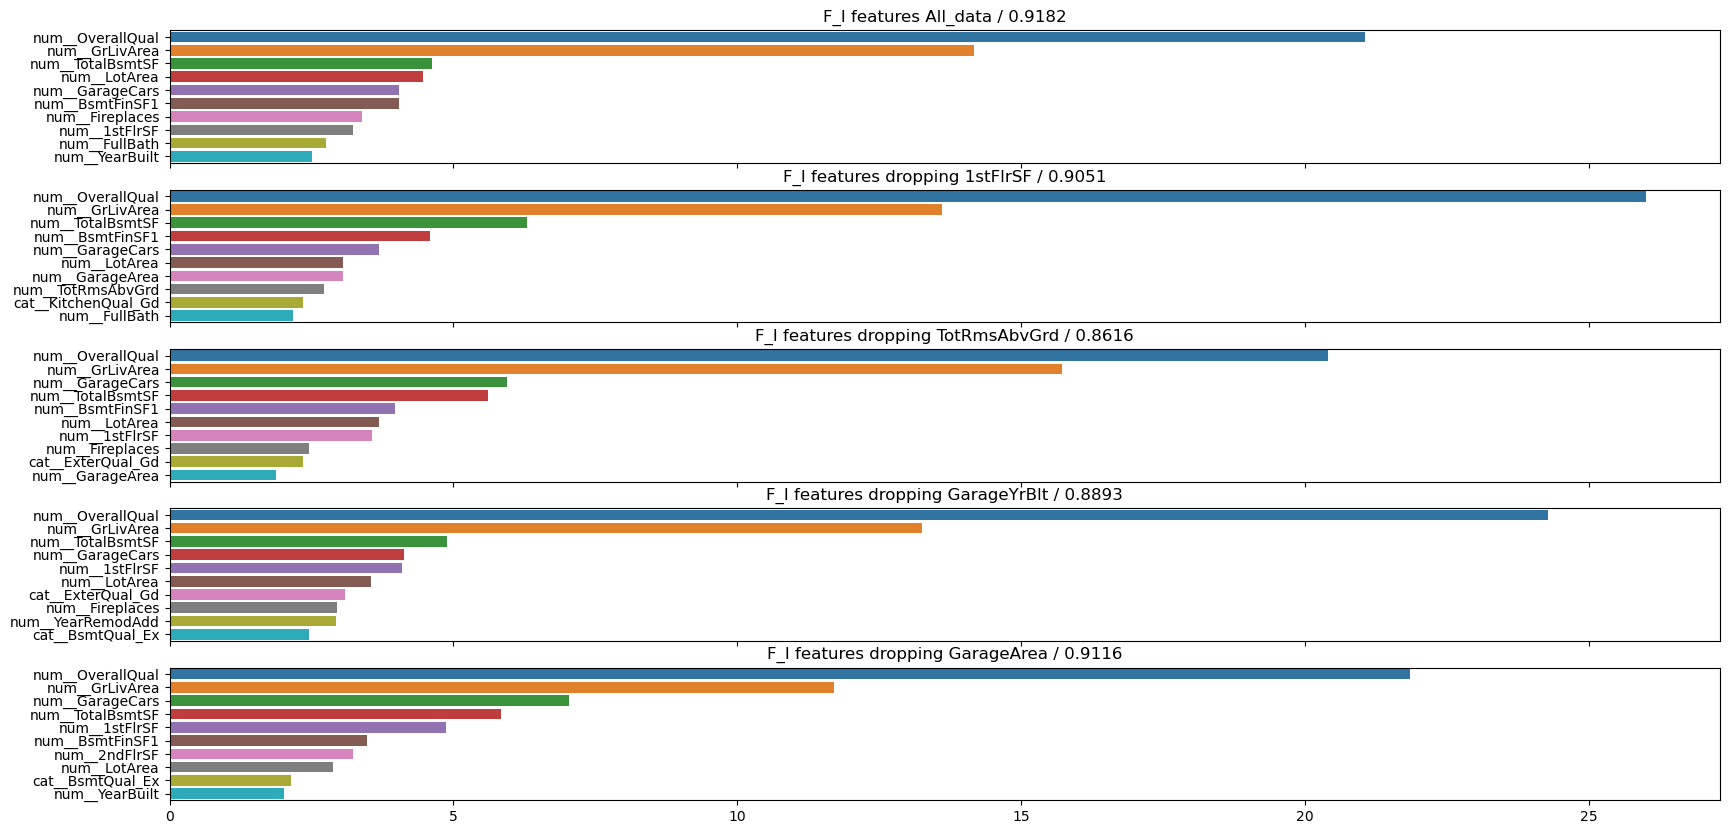

In [133]:
np.random.seed(42)
drop_list = ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea'] 
test1 = DropProtocol(temp, drop_list, 'SalePrice', CatBoostRegressor(logging_level='Silent'), True)
test1.drop_protocol()

In [7]:
np.random.seed(42)
test2 = DropProtocol(temp, temp.drop('SalePrice', axis=1).columns, 'SalePrice', CatBoostRegressor(logging_level='Silent'), False)
cols_to_drop = test2.drop_protocol()

Starting Drop-Protocol for a list of 79 columns.......
                          Score
dropping Exterior2nd   0.936621
dropping BsmtUnfSF     0.935183
dropping CentralAir    0.933982
dropping MasVnrArea    0.932550
dropping PoolArea      0.932362
dropping SaleType      0.931003
dropping FullBath      0.927738
dropping Electrical    0.927313
dropping FireplaceQu   0.926871
dropping GarageArea    0.926525
dropping LowQualFinSF  0.926130
dropping LandSlope     0.924926
dropping ScreenPorch   0.923866
dropping YearRemodAdd  0.923120
dropping PavedDrive    0.922897
dropping BldgType      0.922794
dropping GrLivArea     0.921407
dropping GarageQual    0.919271
dropping Fence         0.918936
All_data               0.918230


In [106]:
print(temp['Alley'].isna().sum() * 100 / len(temp),
      temp['PoolQC'].isna().sum() * 100 / len(temp),
      temp['Fence'].isna().sum() * 100 / len(temp),
      temp['MiscFeature'].isna().sum() * 100 / len(temp),
      temp['FireplaceQu'].isna().sum() * 100 / len(temp))

93.76712328767124 99.52054794520548 80.75342465753425 96.3013698630137 47.26027397260274


In [2]:
ts_temp = pd.read_csv('test.csv')
ts_temp = ts_temp.drop('Id', axis=1)
# ts_temp = ts_temp.drop(list(map(lambda x: x.replace('dropping ', ''), cols_to_drop.index[:1])), axis=1)

In [3]:
tr_temp = pd.read_csv('train.csv')
tr_temp = tr_temp.drop('Id', axis=1)

In [4]:
# Equal categorical values between train_df and test_df
print('Cols no included in test_df:')
for col in tr_temp.select_dtypes(include=object).columns:
    for val in tr_temp[col].unique():
            if val not in ts_temp[col].unique() and val == val:
                print(tr_temp[col].name, val, len(tr_temp.loc[tr_temp[col] == val]))
                tr_temp[col].loc[tr_temp[col] == val] = np.nan

Cols no included in test_df:
Utilities NoSeWa 1
Condition2 RRNn 2
Condition2 RRAn 1
Condition2 RRAe 1
HouseStyle 2.5Fin 8
RoofMatl Metal 1
RoofMatl Membran 1
RoofMatl Roll 1
RoofMatl ClyTile 1
Exterior1st Stone 2
Exterior1st ImStucc 1
Exterior2nd Other 1
Heating OthW 2
Heating Floor 1
Electrical Mix 1
GarageQual Ex 3
PoolQC Fa 2
MiscFeature TenC 1


/tmp/ipykernel_160766/1656137350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_temp[col].loc[tr_temp[col] == val] = np.nan


In [491]:
ts_temp = ts_temp.drop('Exterior2nd', axis=1)
tr_temp = tr_temp.drop('Exterior2nd', axis=1)

In [80]:
np.random.seed(42)
pre_X, f_imp = less_data_test1.processor(tr_temp.drop('SalePrice', axis=1))
model = CatBoostRegressor(logging_level='Silent')
X_train, X_test, y_train, y_test = train_test_split(pre_X, tr_temp['SalePrice'])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9145399956961734

# GridSearch with RandomForest and CatBoost

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# RandomForest
np.random.seed(42)

cat_features = tr_temp.select_dtypes(include=object).columns
num_features = tr_temp.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfr', RandomForestRegressor())
])

grid = {
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
    'preprocessor__num__imputer__strategy': ['mean', 'most_frequent', 'median'],
    'rfr__n_estimators': [1000, 2000, 5000]
}

X_train, X_test, y_train, y_test = train_test_split(tr_temp.drop('SalePrice', axis=1), tr_temp['SalePrice'])
print('Training.......')

rfr_gs = GridSearchCV(estimator=model,
                      param_grid=grid,
                      cv=2,
                      verbose=1,
                      n_jobs=-1)
rfr_gs.fit(X_train, y_train)
print('.....Finish')

Training.......
Fitting 2 folds for each of 18 candidates, totalling 36 fits
.....Finish


In [70]:
rfr_gs.best_params_

{'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__num__imputer__strategy': 'median',
 'rfr__n_estimators': 2000}

In [74]:
# CatBoost
np.random.seed(42)


cat_features = tr_temp.select_dtypes(include=object).columns
num_features = tr_temp.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catb', CatBoostRegressor(loss_function='RMSE', logging_level='Silent'))
])

cat_grid = {
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
    'preprocessor__num__imputer__strategy': ['most_frequent', 'median'],
    'catb__iterations': [500, 10000, 15000],
    'catb__learning_rate': [0.3, 0.4, 0.5],
    'catb__max_depth': [4, 5],
    'catb__min_data_in_leaf': [0.5, 1],
    'catb__l2_leaf_reg': [5, 6]
}

X_train, X_test, y_train, y_test = train_test_split(tr_temp.drop('SalePrice', axis=1), tr_temp['SalePrice'])
print('Training.......')

catb_gs = GridSearchCV(estimator=model,
                      param_grid=cat_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=1)
catb_gs.fit(X_train, y_train)
print('.....Finish')

Training.......
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
.....Finish


In [75]:
catb_gs.best_params_

{'catb__iterations': 15000,
 'catb__l2_leaf_reg': 6,
 'catb__learning_rate': 0.4,
 'catb__max_depth': 5,
 'catb__min_data_in_leaf': 0.5,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__num__imputer__strategy': 'median'}

# Catboost with folds

In [10]:
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from time import sleep

In [495]:
tr_temp['SalePrice'].dtype

dtype('int64')

In [5]:
ts_temp.loc[len(ts_temp)] = np.nan
tr_temp.loc[len(ts_temp)] = np.nan
tr_temp['SalePrice'].fillna(0, inplace=True)
tr_temp['SalePrice'] = tr_temp['SalePrice'].astype(np.int64)

In [7]:
display(tr_temp.tail(), ts_temp.tail())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1456,20.0,RL,85.0,13175.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,MnPrv,NaN,0.0,2.0,2010.0,WD,Normal,210000
1457,70.0,RL,66.0,9042.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,GdPrv,Shed,2500.0,5.0,2010.0,WD,Normal,266500
1458,20.0,RL,68.0,9717.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,4.0,2010.0,WD,Normal,142125
1459,20.0,RL,75.0,9937.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,6.0,2008.0,WD,Normal,147500
1460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1455,160.0,RM,21.0,1894.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,4.0,2006.0,WD,Abnorml
1456,20.0,RL,160.0,20000.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9.0,2006.0,WD,Abnorml
1457,85.0,RL,62.0,10441.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,MnPrv,Shed,700.0,7.0,2006.0,WD,Normal
1458,60.0,RL,74.0,9627.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,11.0,2006.0,WD,Normal
1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
tr_temp.drop('SalePrice', axis=1).shape, ts_temp.shape, preprocessor.fit_transform(tr_temp.drop('SalePrice', axis=1)).shape, preprocessor.fit_transform(ts_temp).shape

NameError: name 'preprocessor' is not defined

In [463]:
preprocessor.fit_transform(tr_temp.drop('SalePrice', axis=1))
t1 = preprocessor.get_feature_names_out()

In [464]:
preprocessor.fit_transform(ts_temp)
t2 = preprocessor.get_feature_names_out()

In [465]:
[x for x in t1 if x not in t2]

[]

In [440]:
np.random.seed(42)
X = tr_temp.drop('SalePrice', axis=1)
y = tr_temp['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y)
model = CatBoostRegressor(logging_level='Silent')
model.fit(X_train, y_train)
preds = model.predict(preprocessor.fit_transform(ts_temp))
preds

array([123658.68487544, 165170.45523532, 183593.1594939 , ...,
       119875.62449069, 224025.92606652, 165558.33898134])

In [22]:
# Preds with folds
np.random.seed(42)

n_folds = 4
folds = StratifiedKFold(n_splits=n_folds, shuffle=True)

cat_features = tr_temp.select_dtypes(include=object).columns
num_features = tr_temp.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)
params = {
    'loss_function': 'RMSE',
    'logging_level': 'Silent',
    'iterations': 1000000,
    'l2_leaf_reg': 6,
    'learning_rate': 0.4,
    'max_depth': 5,
    'min_data_in_leaf': 0.5,
}
pre_test = preprocessor.fit_transform(ts_temp)
test_data = Pool(pre_test)
scores = []
preds = np.zeros(test_data.shape[0])
X = preprocessor.fit_transform(tr_temp.drop('SalePrice', axis=1))
y = tr_temp['SalePrice']
for fold_n, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    train_data = Pool(data=X_train,
                     label=y_train)
    valid_data = Pool(data=X_valid,
                    label=y_valid)
    model = CatBoostRegressor(**params)
    model.fit(train_data,
             eval_set=valid_data,
             use_best_model=True)
    
    score = model.get_best_score()['validation']['RMSE']
    scores.append(score)
    y_pred = model.predict(test_data)
    preds += y_pred

preds /= n_folds
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

/home/manu/Proyectos/data-science/House-Pricing/env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


CV mean: 27585.9247, CV std: 4128.2383


# Push result to Kaggle

In [69]:
example = pd.read_csv('sample_submission.csv')
example.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [85]:
preds = model.predict(preprocessor.fit_transform(test_df))
preds

array([122404.71787831, 161376.01691974, 184103.42960976, ...,
       157269.70573119, 120448.20342945, 227099.25167983])

In [20]:
submission_df = pd.DataFrame(zip(pd.read_csv('test.csv', )['Id'], preds), columns=['Id', 'SalePrice'])
display(submission_df.head(), len(submission_df), len(pd.read_csv('test.csv')))

,Id,SalePrice
0,1461,117253.428429
1,1462,156618.509957
2,1463,188900.917608
3,1464,191010.962803
4,1465,176464.947546


1459

1459

In [21]:
submission_df.to_csv('Catb-StratifiedKFold-5.csv', index=False)